#**Detecting Fake Reviews with Attention**





#*An Attention Layer from Scratch*

We think to ourselves that maybe, instead of having the LSTM figure out a compressed representation of the sequence in a 'fixed' manner, giving fixed 'weighting' or 'attention' to the particular words in a sequence, across observations, we should provide it the flexibility to decide which words are more or less important, depending on the joint set of words seen. This 'flexibility' to shift focus depending on the combinations of encountered tokens is exactly what attention seeks to achieve. We are going to implement an attention layer here, from scratch, which receives all the hidden states of the LSTM (rather than just the final hidden state), and it's going to provide the ability to highlight different words when constructing the sequence embedding, depending on the values that are present in the sequence. Here, we need one weight for each dimension of the embedding space that words were cast into. Imagine a 2D latent space, of long vs. short, and noun vs. not noun (or something - I made this up). Our weights might adapt under training to enable our model to focus more on long vs. short words, and nouns versus non-nouns, when formulating its prediction. Obviously, our embedding space captures latent semantic notions that we cannot articulate, but this is what it is doing conceptually.

Let's reimport and process our dataset as before.

In [7]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from google.colab import files
import pandas as pd
import io
import numpy as np

from google.colab import drive

drive.mount('/content/drive')
trip_advisor = pd.read_csv("drive/My Drive/Teaching/Courses/BA 865/BA865-2025/Lecture Materials/Week 4/datasets/deceptive-opinion.csv")

# Just load the data from the Week 3 folder again and shuffle.
trip_advisor = trip_advisor.sample(frac=1) # Shuffle the data since I'll eventually just use a simple validation split.

trip_advisor.describe(include='all')

trip_advisor_text = trip_advisor['text'].to_numpy()
label = np.where(trip_advisor['deceptive']=='deceptive',1,0)

print(trip_advisor_text)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['This hotel is great! I love its interior design of the room. Customer service is excellent! And its gym and spa are gorgeous. If you need to go to Chicago, this hotel would be your best choice! You can also check its website for the special offer, I found a great deal on it! \n'
 "I arrived at the hotel 15 minutes prior to check in time as they recommend. When I get there I noticed that there is a couple and two other people waiting in line to check in. Ten minutes later after standing there with my suitcase, the woman at the front desk informs us that their computers are down due to a recent update to the software. She told us to wait until the computers booted back up. I asked if I could drop my suitcase off at the room and she said no because they need to electronically activate the cards and with the computers down they couldn't activate the cards. Fina

Let's make a TextVectorization() layer to preprocess our text.

In [25]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # adding more tokens to allow for increase due to bigrams.
    output_mode="multi_hot", # This is requesting multihot encodings (which means we'll have a fixed vector of 1's and 0's per review)
)

text_vectorization.adapt(trip_advisor_text)

We are going to start off with one-hot encodings again, just to make sure we understand the shapes of all the tensors and things as we go along, so we understand what the network is doing!

In [26]:
processed_text = text_vectorization(trip_advisor_text)

# We have 1,600 reviews, with 2000 dummies for our vocab.
print(processed_text.shape)

(1600, 2000)


In [27]:
processed_text[0]

<tf.Tensor: shape=(2000,), dtype=int64, numpy=array([0, 1, 1, ..., 0, 0, 0])>

Now we can make our network...

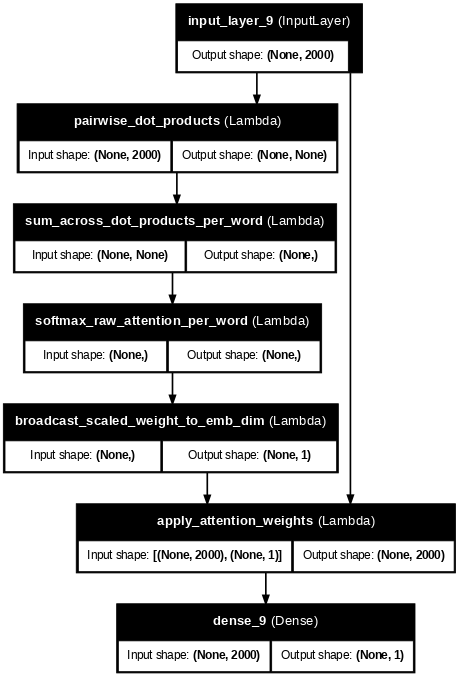

In [29]:
from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda, Dense

def build_model():
    # Now, let's start specifying our model...
    inputs = keras.layers.Input(shape=[2000,]) # We take the sequence of 1-hot encodings as input.

    # 1. Calculate dot products between all pairs of word embeddings
    dot_products = Lambda(lambda x: tf.matmul(x, x, transpose_b=True),name="pairwise_dot_products")(inputs)  # (batch_size, seq_len, seq_len)

    # 2. Sum dot products for each word to get attention scores
    attention_scores = Lambda(lambda x: tf.reduce_sum(x, axis=-1),name="sum_across_dot_products_per_word")(dot_products)  # (batch_size, seq_len)

    # 3. Apply softmax to normalize attention scores
    attention_weights = Lambda(lambda x: tf.nn.softmax(x, axis=-1),name="softmax_raw_attention_per_word")(attention_scores)  # (batch_size, seq_len)

    # 4. Reshape attention weights for broadcasting
    attention_weights = Lambda(lambda x: tf.expand_dims(x, axis=-1),name="broadcast_scaled_weight_to_emb_dim")(attention_weights)  # (batch_size, seq_len, 1)

    # 5. Multiply embeddings by attention weights
    attention_output = Lambda(lambda x: x[0] * x[1],name="apply_attention_weights")([inputs, attention_weights])  # (batch_size, seq_len, embedding_dim)

    outputs = keras.layers.Dense(1, activation="sigmoid")(attention_output)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

model = build_model()
keras.utils.plot_model(model,show_shapes=True,dpi=60,show_layer_names=True)

Let's get our data ready...

And, let's try fitting this model... our custom attention layer actually does quite well!

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint("attention_from_scratch.keras",
                                    save_best_only=True)
]

model = build_model()
history = model.fit(processed_text, label,
                        validation_split=0.2,
                        epochs=20, batch_size=1,callbacks=callbacks)

Epoch 1/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6711 - loss: 0.6278 - val_accuracy: 0.8188 - val_loss: 0.4813
Epoch 2/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8814 - loss: 0.4182 - val_accuracy: 0.8469 - val_loss: 0.3996
Epoch 3/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9100 - loss: 0.3197 - val_accuracy: 0.8687 - val_loss: 0.3564
Epoch 4/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9254 - loss: 0.2470 - val_accuracy: 0.8687 - val_loss: 0.3347
Epoch 5/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9370 - loss: 0.2105 - val_accuracy: 0.8781 - val_loss: 0.3146
Epoch 6/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9349 - loss: 0.1884 - val_accuracy: 0.8844 - val_loss: 0.3046
Epoch 7/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9459 - loss: 0.1705 - val_accuracy: 0.8656 - val_loss: 0.2947
Epoch 8/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9303 - loss: 0.1818 - 

And, plotting model performance, as well as evaluating against the test set, what do we get... our best model yields about 80% accuracy in the test data.

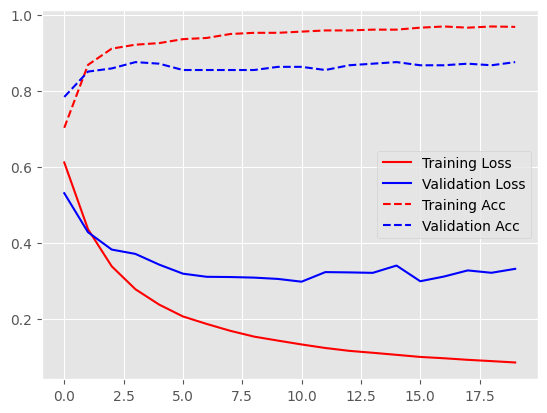

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

#*QKV Framework Attention Layer*

In [35]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=784, # sequence length
    pad_to_max_tokens=True, # pad to max length
    output_mode="int", # This is requesting multihot encodings (which means we'll have a fixed vector of 1's and 0's per review)
)

text_vectorization.adapt(trip_advisor_text)

processed_text = text_vectorization(trip_advisor_text)

# We have 1,600 reviews, with up to 784 tokens in each sequence (including padding)
print(processed_text.shape)

print(processed_text[0])

print(trip_advisor_text[0])

(1600, 784)
tf.Tensor(
[ 23  10  17  40   6 457  90   1   1   9   2  13 264  45  17 191   3  90
 529   3 439  44 666  54  33 227   4 106   4  25  23  10  39  34 113 136
 508  33 120  76 122  90 312  12   2 433 337   6 142   5  40 336  24  14
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0

We can leverage the code from the book for a Transformer of course.

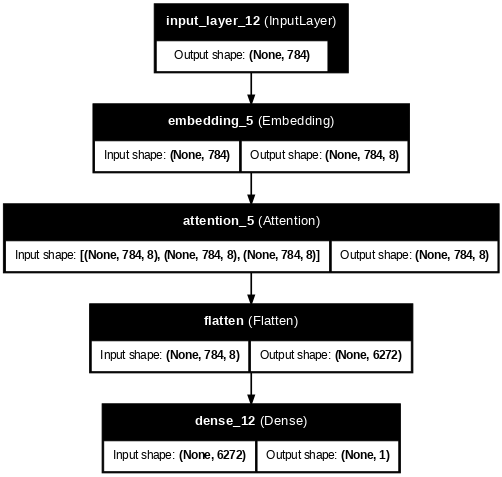

In [38]:
from keras.layers import Flatten, Activation, RepeatVector, Permute, Multiply, Lambda, Dense

def build_attention_model():
    # Now, let's start specifying our model...
    inputs = keras.layers.Input(shape=(784,)) # We take the sequence of 1-hot encodings as input.

    embedding_layer = layers.Embedding(784,8)
    embeddings = embedding_layer(inputs)

    # We implement self-attention here; the input serves as the query, the key (comparison), and is also the value against which attention scores are applied.
    attention_weighted_embeddings = keras.layers.Attention()([embeddings,embeddings,embeddings])

    flatten = layers.Flatten()(attention_weighted_embeddings)

    outputs = keras.layers.Dense(1, activation="sigmoid")(flatten)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=['accuracy'])
    return model

attention_model = build_attention_model()
keras.utils.plot_model(attention_model,show_shapes=True,dpi=60,show_layer_names=True)

We have max length of 2000 terms, and thus one-hot encodings means we have

In [39]:
callbacks = [
    keras.callbacks.ModelCheckpoint("attention_model.keras",
                                    save_best_only=True)
]

history = attention_model.fit(processed_text,
                              label, # User calls .fit on model, not attention_model
                        validation_split=0.2,
                        epochs=20, batch_size=1,callbacks=callbacks)

Epoch 1/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.5112 - loss: 0.7508 - val_accuracy: 0.4625 - val_loss: 0.7333
Epoch 2/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5145 - loss: 0.7486 - val_accuracy: 0.4594 - val_loss: 1.4590
Epoch 3/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5322 - loss: 0.7529 - val_accuracy: 0.4594 - val_loss: 0.8955
Epoch 4/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6597 - loss: 0.6465 - val_accuracy: 0.6594 - val_loss: 0.6707
Epoch 5/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7470 - loss: 0.5182 - val_accuracy: 0.7125 - val_loss: 0.6073
Epoch 6/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8006 - loss: 0.4679 - val_accuracy: 0.7375 - val_loss: 0.5814
Epoch 7/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8415 - loss: 0.3917 - val_accuracy: 0.7625 - val_loss: 0.5946
Epoch 8/20
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8412 - loss: 0.3465 - 

And plotting loss over training, and checking loss against test set... this model is also pretty good - it performs similarly, getting us to about 83% accuracy.

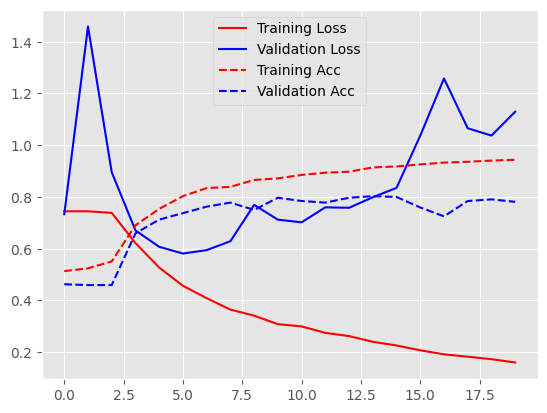

In [40]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()